## LAM and Fibro GWAS dotplots

In [1]:
import scanpy as sc
import pandas as  pd
import numpy as np
import sys
import scipy as sp
from pathlib import Path

In [2]:
sys.path.append(str(Path.home() / 'Code/sctoolkit/'))

In [3]:
from sctoolkit.utils import sort_by_correlation

In [4]:
from plotnine import *

In [5]:
lam_genes = [
    'SPP1', 'FABP5', 'APOC1', 'CSTB', 'GPNMB', 'LGALS3', 'CD9', 'LPL', 'CD52', 'LIPA', 'PLA2G7', 'APOE', 'ITGAX', 'LGALS1', 'CYP27A1', 'AQP9', 'SDS', 'C15orf48', 'RAB7B', 'CAPG', 'MMP19', 'FBP1', 'LSP1', 'CD109', 'SDC2', 'PHLDA1', 'TREM2', 'PPARG', 'MATK', 'PLIN2',
]
lam_genes = sorted(set(lam_genes))

In [6]:
lung_fibro_genes = ['NPNT', 'LIMCH1', 'ITGA8', 'FRAS1', 'ADAMTS12', 'GPC3', 'FGFR4', 'FRAS1', 'FREM1']

In [7]:
bestgenes = pd.read_pickle(Path.home() / 'Code/opentargets-genetics-python/data/bestgenes.pkl')
info = pd.read_pickle(Path.home() / 'Code/opentargets-genetics-python/data/info.pkl')

In [8]:
pd.options.display.max_columns = 100

In [10]:
l2g_table = bestgenes.explode(['bestLocus2Genes_id', 'bestLocus2Genes_symbol', 'bestLocus2Genes_score'])[['bestLocus2Genes_id', 'bestLocus2Genes_symbol', 'bestLocus2Genes_score', 'pval', 'oddsRatio']]
l2g_table = l2g_table.merge(info.reset_index()[['traitReported', 'nTotal', 'studyId']], left_on='study', right_on='studyId')

l2g_table['pval'] = -np.log10(l2g_table['pval'])
l2g_table['bestLocus2Genes_score'] = l2g_table['bestLocus2Genes_score'].astype(float)
l2g_table['oddsRatio'] = l2g_table['oddsRatio'].astype(float)
l2g_table = l2g_table.groupby(['traitReported', 'bestLocus2Genes_symbol'], observed=False).agg({'pval':np.max, 'bestLocus2Genes_score': np.max, 'oddsRatio': np.nanmax}).reset_index()

l2g_table = l2g_table[l2g_table.traitReported.notna() & (l2g_table.traitReported!= 'NaN')]
l2g_table

,traitReported,bestLocus2Genes_symbol,pval,bestLocus2Genes_score,oddsRatio
0,3mm asymmetry angle (left),CWC27,13.251812,0.548806,NaN
1,3mm asymmetry angle (left),GPHB5,7.822140,0.615300,NaN
2,3mm asymmetry angle (left),KIF6,8.894020,0.650048,NaN
3,3mm asymmetry angle (right),GPHB5,8.144996,0.615300,NaN
4,3mm asymmetry angle (right),SETBP1,7.856579,0.677927,NaN
...,...,...,...,...,...
35678,middle facial morphology traits (quantitative ...,SFRP2,7.698970,0.697430,NaN
35679,middle facial morphology traits (quantitative ...,GLI3,9.301030,0.867207,NaN
35680,nicotine metabolite ratio in current smokers,AC008537.1,39.000000,0.664125,NaN
35681,nicotine metabolite ratio in current smokers,CYP2A6,50.000000,0.691910,NaN


## NPNT figure

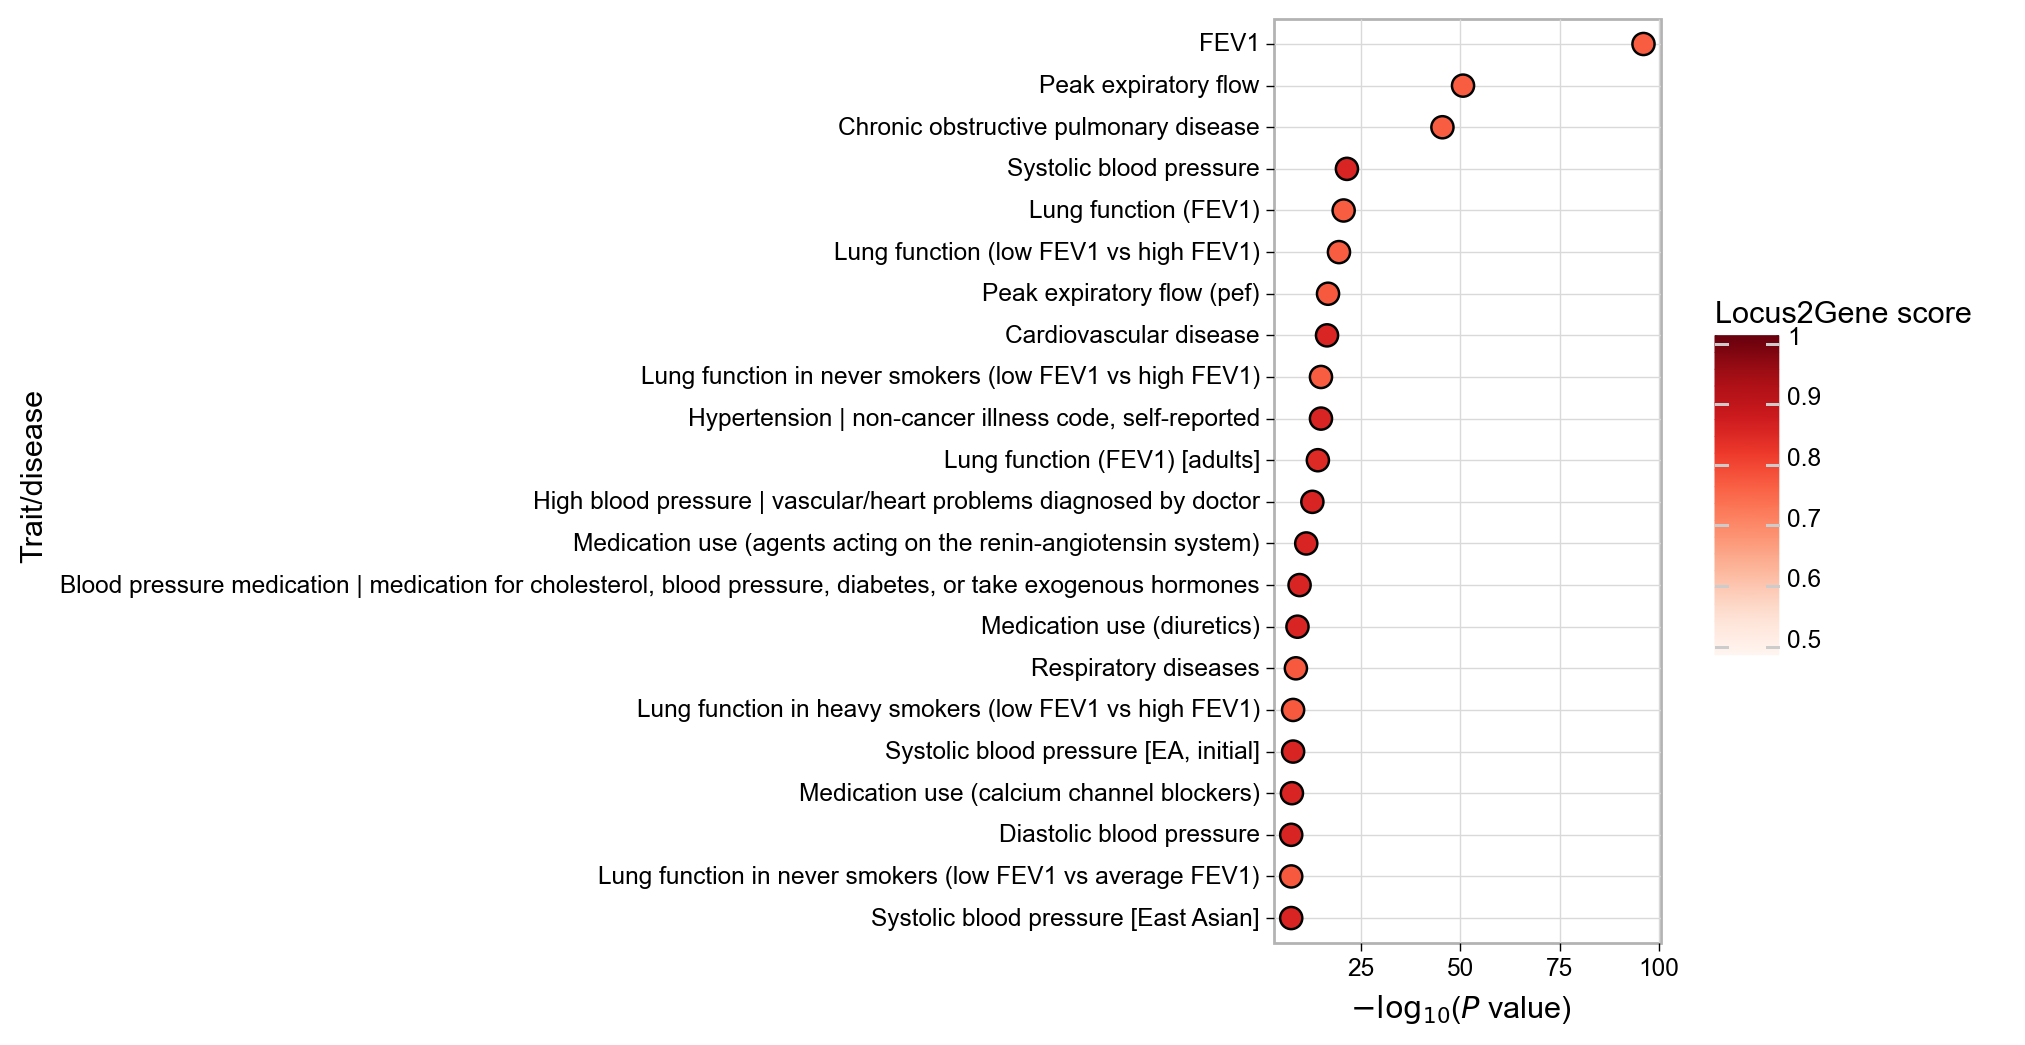

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.5 x 6 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure-4-G.pdf


In [11]:
npnt = l2g_table[l2g_table.bestLocus2Genes_symbol == 'NPNT'].sort_values('pval', ascending=False)

g = (
    ggplot(data=npnt, mapping=aes(x='reorder(traitReported, pval)', y='pval')) + 
    #geom_segment(aes(x='reorder(module, -logOR)', xend='reorder(module, -logOR)', y=1.2, yend='logOR')) +    
    geom_point(aes(fill='bestLocus2Genes_score'), size=4) + 
    scale_fill_cmap('Reds', limits=(0.5, 1.)) + 
    #scale_y_continuous(limits=(0,None))+
    labs(x='Trait/disease', y='$-\log_{10}$($P$ value)', fill='Locus2Gene score') +
    coord_flip() +
    theme_light() +
    theme(
        figure_size=(2.5,6),
        text=element_text(family='Arial', color='black'),
        panel_grid_minor=element_blank(),
    )
)

print(g)

## Myeloid GWAS

In [26]:
gwas_final_table = []

In [27]:
de = pd.read_pickle('mac1-mac2-highlight-DE-genes.pkl')
hlaII_markers = de[de.log2fc<0].gene.tolist()
lyve1_markers = de[de.log2fc>0].gene.tolist()

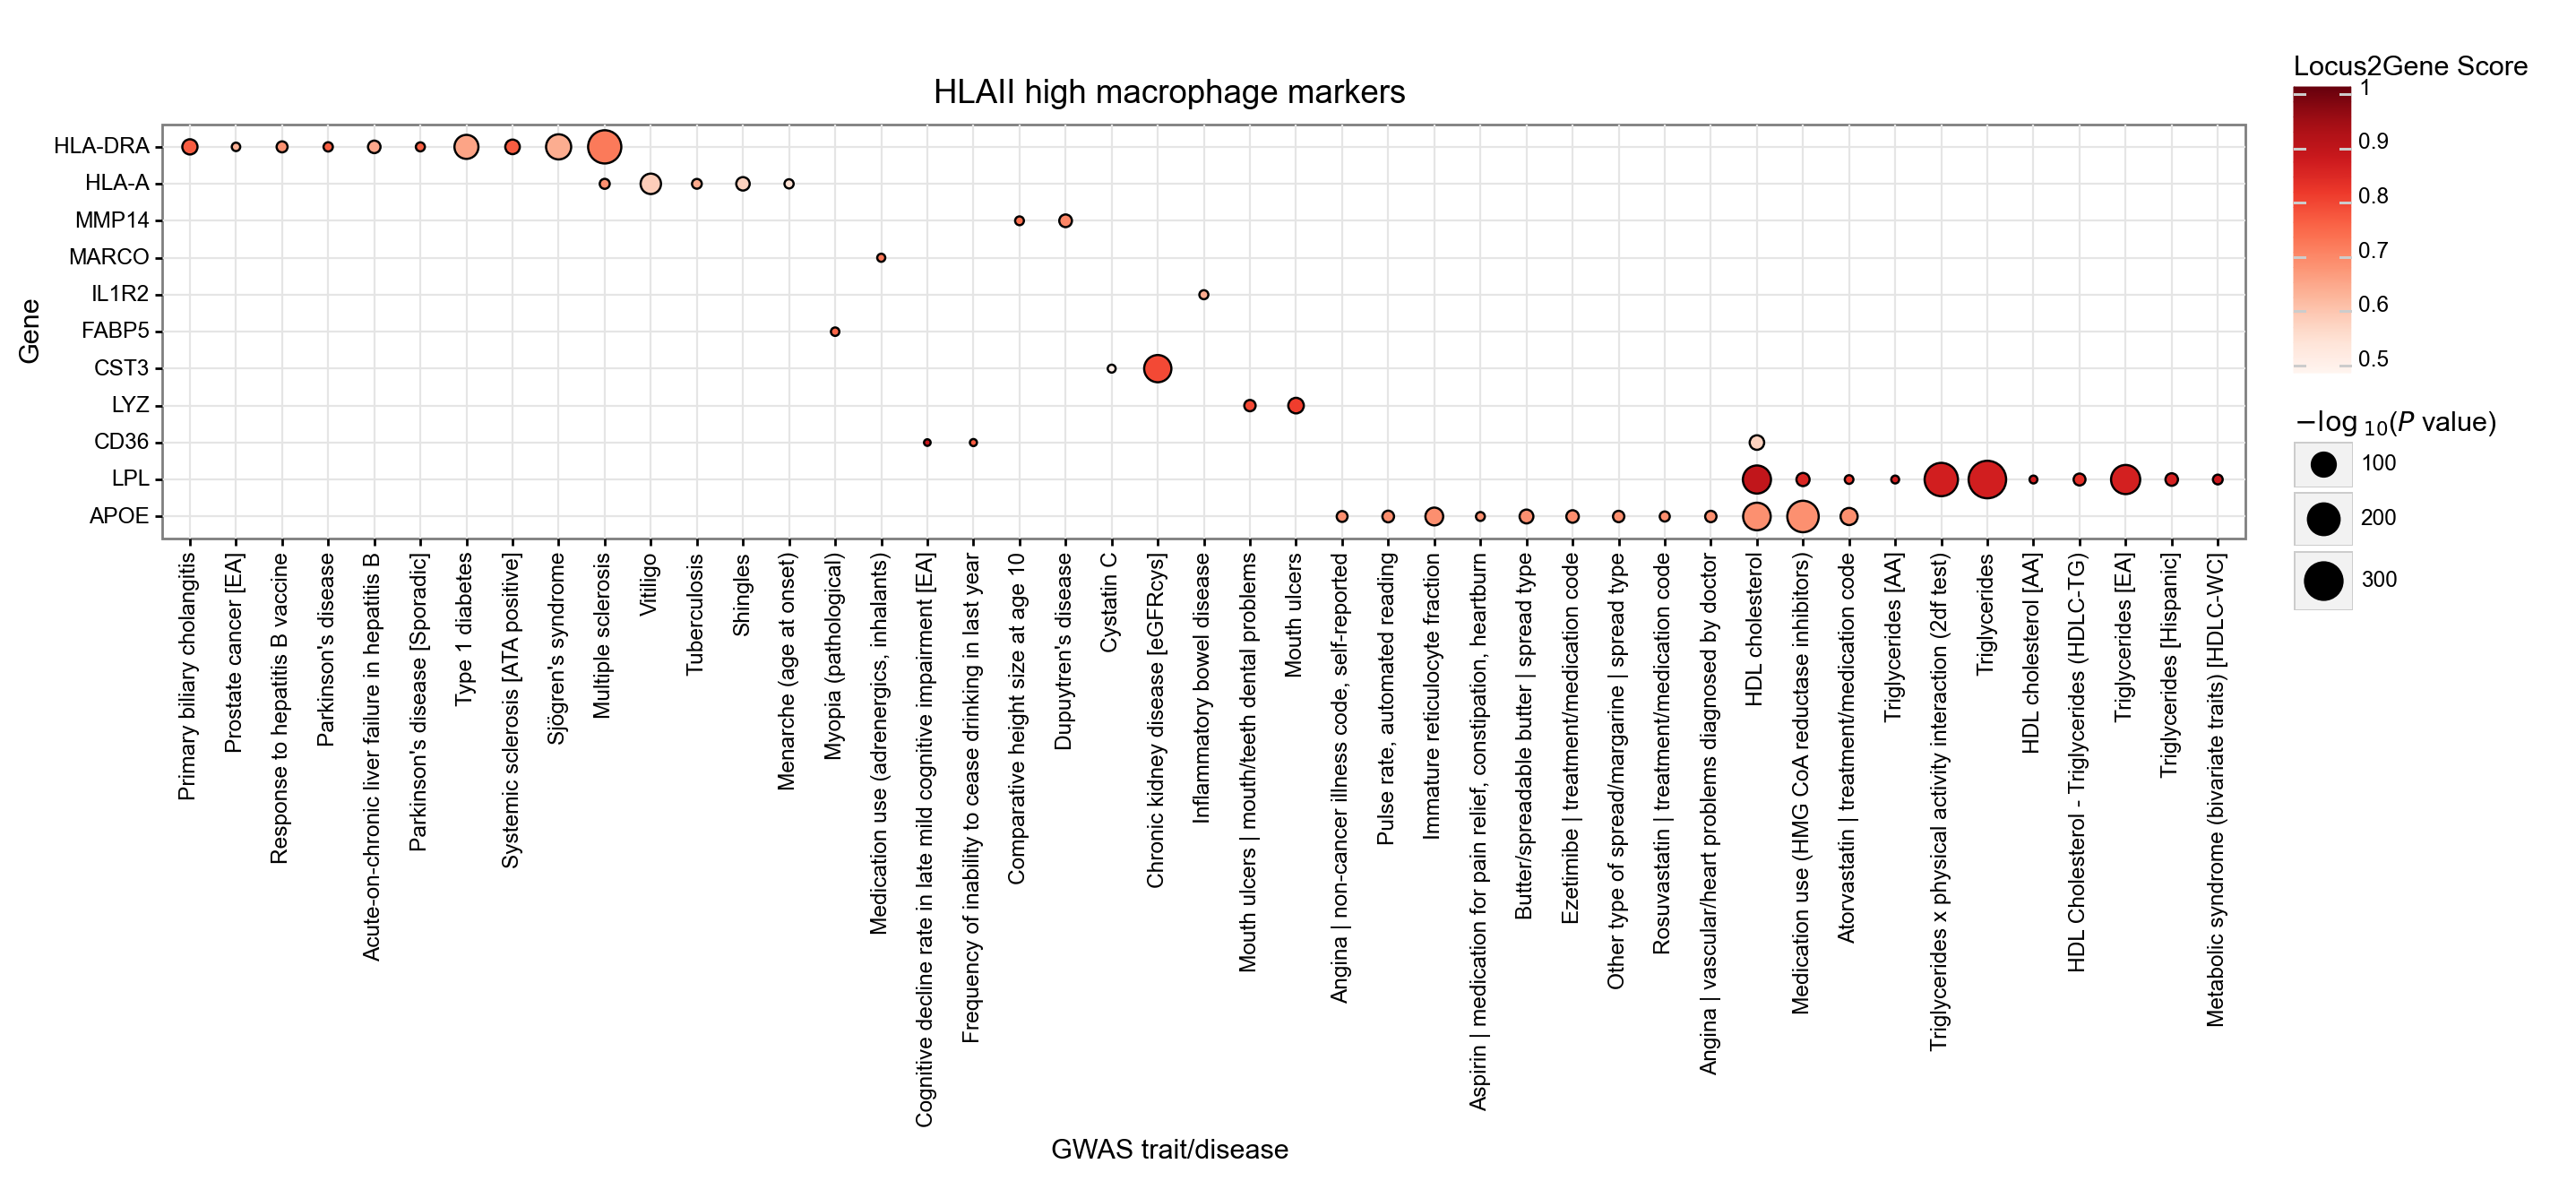

<ggplot: (8773405877285)>

In [30]:
g = hlaII_markers

lung_l2g = l2g_table[l2g_table.bestLocus2Genes_symbol.isin(g)].copy().sort_values('bestLocus2Genes_score', ascending=False)
gwas_final_table.append(lung_l2g.assign(myeloid_state = 'HLAII high'))
tr = lung_l2g.loc[lung_l2g.groupby('bestLocus2Genes_symbol').bestLocus2Genes_score.nlargest(10).reset_index().level_1.values].traitReported
lung_l2g = lung_l2g[lung_l2g.traitReported.isin(tr)]

df = lung_l2g.pivot('traitReported', 'bestLocus2Genes_symbol', 'bestLocus2Genes_score').fillna(0)
idx = sort_by_correlation(df)[::-1]
cats = df.index[idx]

idx = sort_by_correlation(df, rows=False)
genes = df.columns[idx]

lung_l2g['traitReported'] = pd.Categorical(lung_l2g['traitReported'], categories=cats)
lung_l2g['bestLocus2Genes_symbol'] = pd.Categorical(lung_l2g['bestLocus2Genes_symbol'], categories=genes)


(
    ggplot(aes(y='traitReported', x='bestLocus2Genes_symbol'), data=lung_l2g) + 
    geom_point(aes(fill='bestLocus2Genes_score', size='pval'), color='black') + 
    scale_fill_cmap('Reds', limits=(0.5, 1)) + 
    scale_size_continuous(range=(1,8)) +
    coord_flip() +
    labs(y='GWAS trait/disease', x='Gene', fill='Locus2Gene Score', size='$-{\log}_{10}$($P$ value)', title='HLAII high macrophage markers') +
    theme_bw() + 
    theme(figure_size=(15, 3), axis_text_x=element_text(rotation=90), text=element_text(color='black', family='Arial'))
)

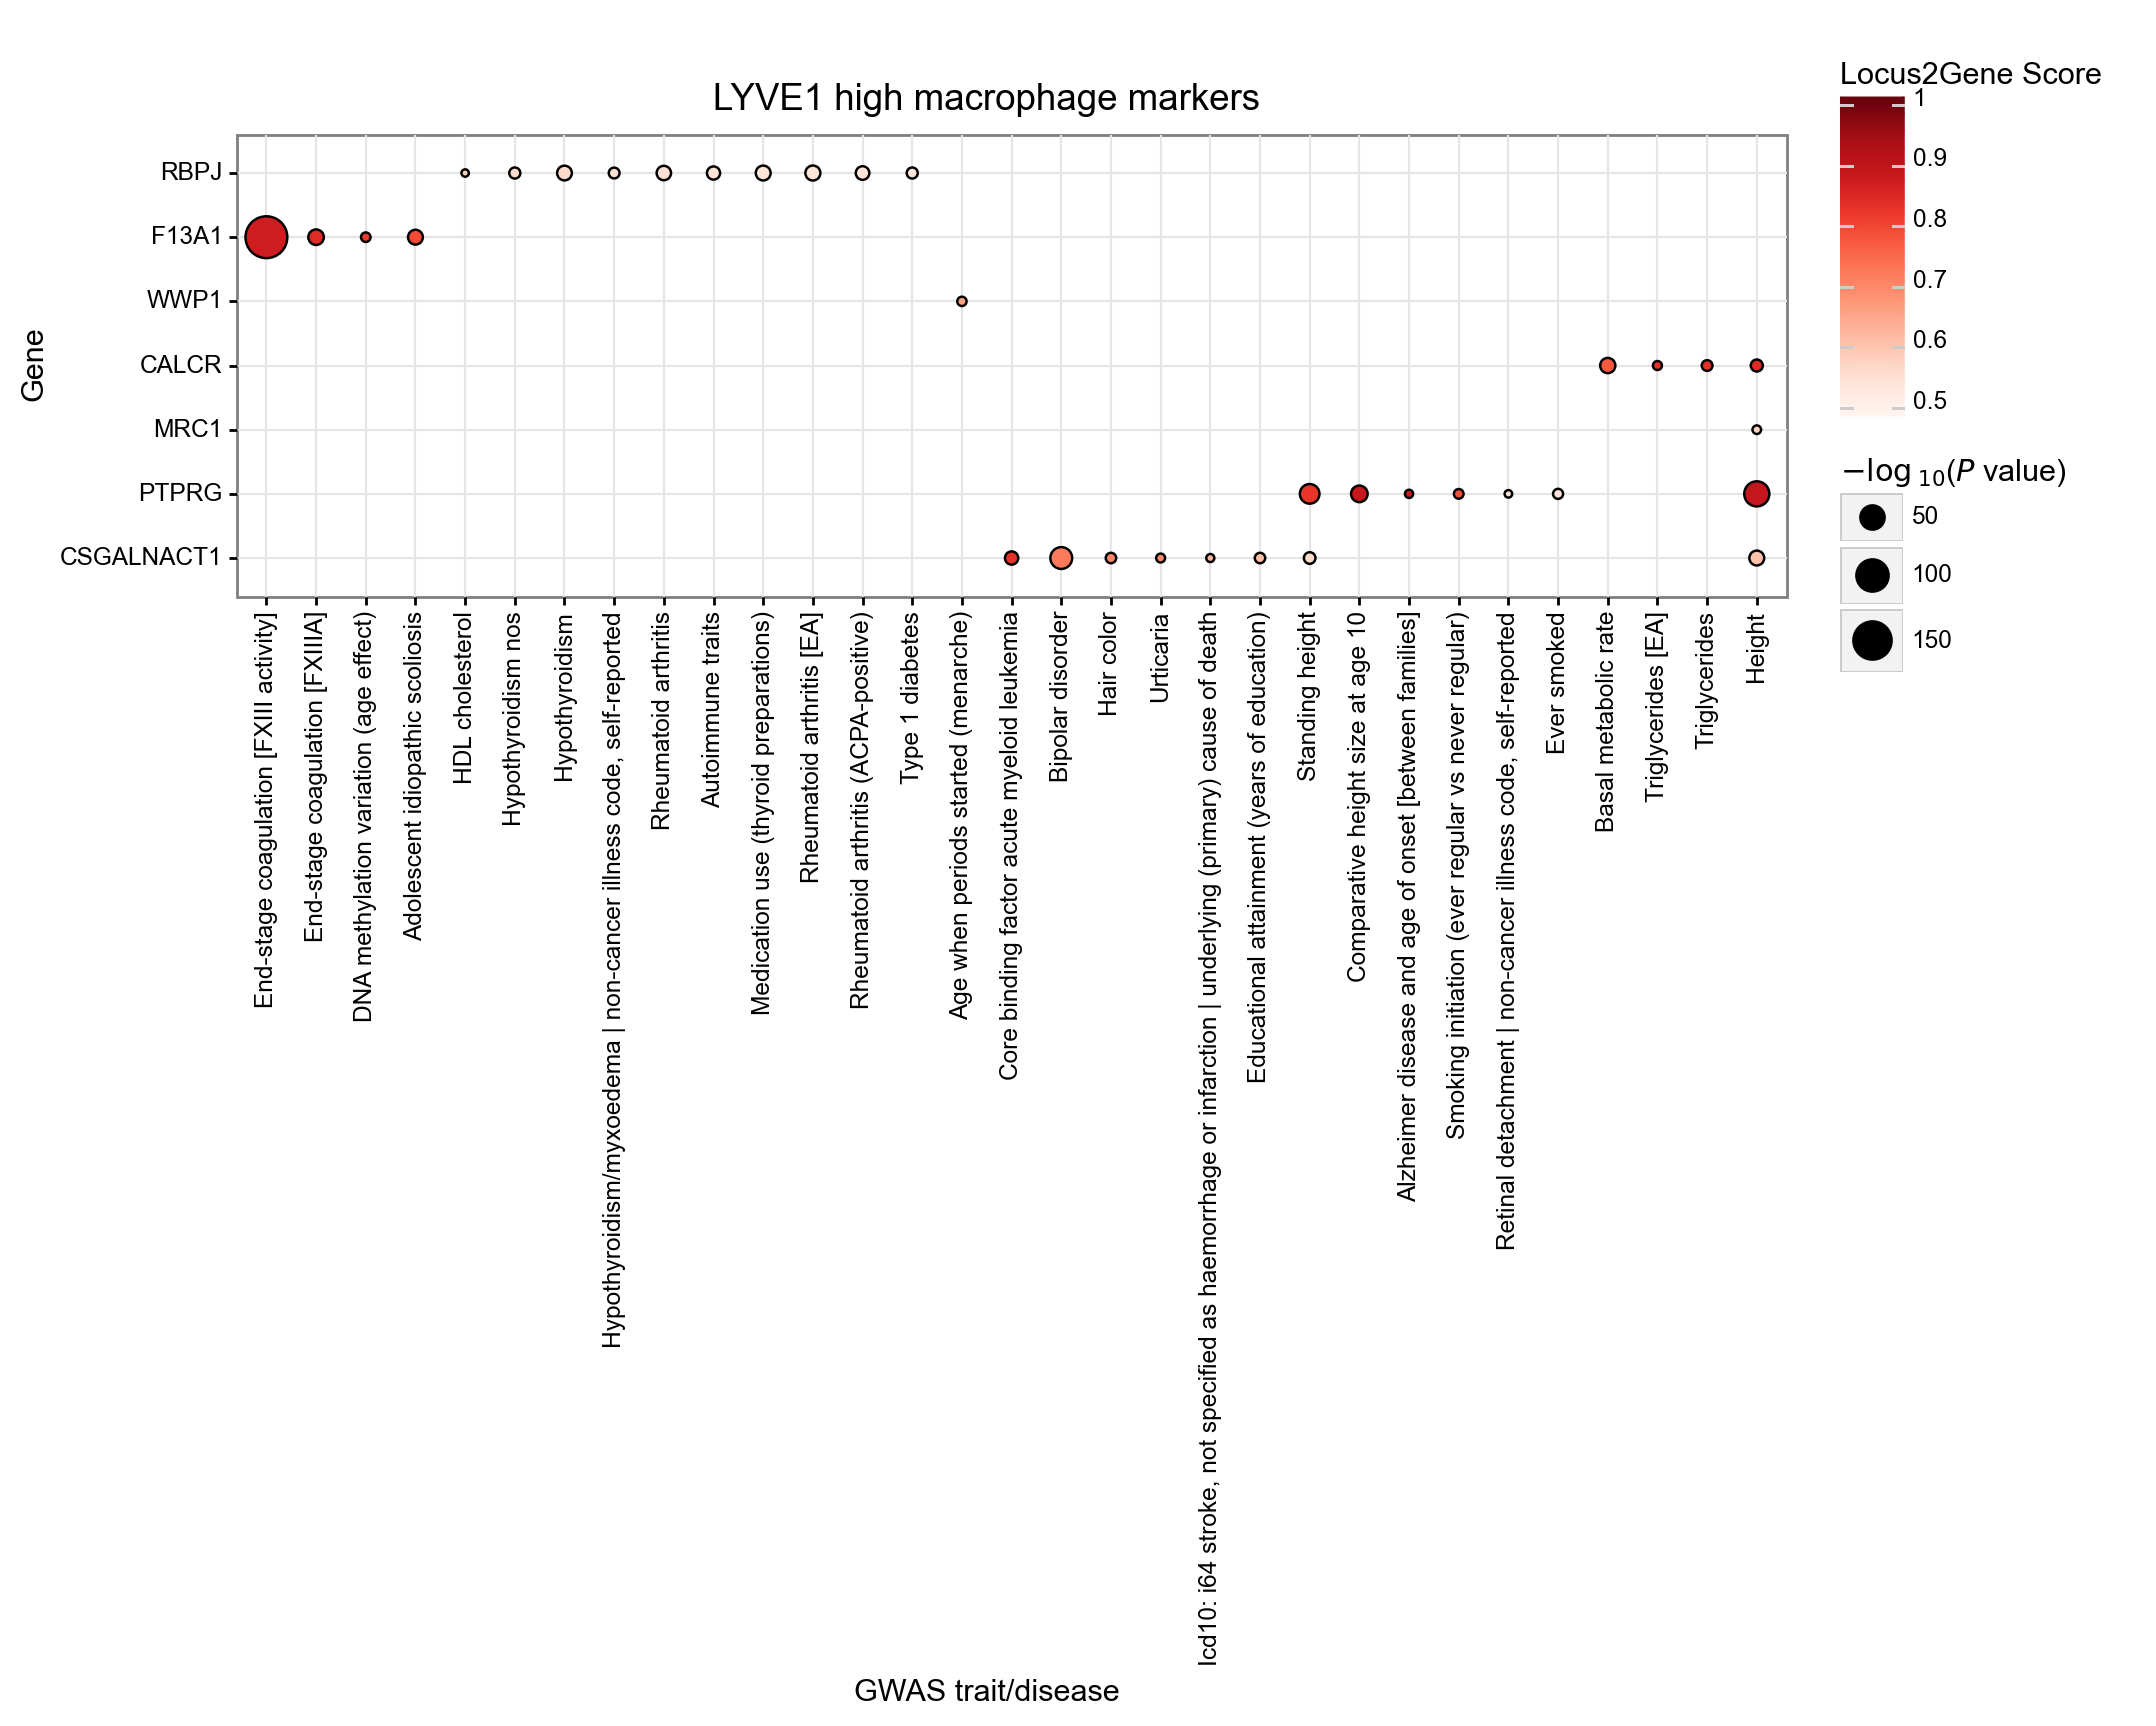

<ggplot: (8773405885245)>

In [32]:
g = lyve1_markers

lung_l2g = l2g_table[l2g_table.bestLocus2Genes_symbol.isin(g)].copy().sort_values('bestLocus2Genes_score', ascending=False)
gwas_final_table.append(lung_l2g.assign(myeloid_state = 'LYVE1 high'))

df = lung_l2g.pivot('traitReported', 'bestLocus2Genes_symbol', 'bestLocus2Genes_score').fillna(0)
idx = sort_by_correlation(df, method='ward', metric='euclidean')
cats = df.index[idx][::-1]

idx = sort_by_correlation(df, rows=False)
genes = df.columns[idx][::-1]

lung_l2g['traitReported'] = pd.Categorical(lung_l2g['traitReported'], categories=cats)
lung_l2g['bestLocus2Genes_symbol'] = pd.Categorical(lung_l2g['bestLocus2Genes_symbol'], categories=genes)


(
    ggplot(aes(y='traitReported', x='bestLocus2Genes_symbol'), data=lung_l2g) + 
    geom_point(aes(fill='bestLocus2Genes_score', size='pval'), color='black') + 
    scale_fill_cmap('Reds', limits=(0.5, 1)) + 
    scale_size_continuous(range=(1,8)) +
    coord_flip()+
    labs(y='GWAS trait/disease', x='Gene', fill='Locus2Gene Score', size='$-{\log}_{10}$($P$ value)', title='LYVE1 high macrophage markers') +
    theme_bw() + 
    theme(figure_size=(10, 3), axis_text_x=element_text(rotation=90), text=element_text(color='black', family='Arial'))
)

## Other fibro genes

In [17]:
final_markers = {
    'Breast': ['FLNB', 'COL1A1', 'COL16A1', 'CD44', 'THBS2'],
    'Esophagus mucosa': ['NTN1', 'SHC3', 'GREM2', 'P2RX2','PLXNB1', 'ADAMTSL1', 'FHOD3', 'FGF13', 'NFATC4', 'PXN', 'SEMA3C', 'FGF14'],
    'Esophagus muscularis': ['SFMBT2', 'SLC2A3','GPRC5A','SOCS3'],
    'Heart': ['CDH19', 'PLA2G5', 'MECOM', 'TBX20', 'ACSM1', 'SOX6', 'GATA4', 'GATA6', 'COL8A1', 'POSTN', 'APOE', 'PCOLCE2', 'SCN7A'],
    'Lung': ['NPNT', 'LIMCH1', 'ITGA8', 'FRAS1', 'ADAMTS12', 'GPC3', 'FGFR4'],
    'Prostate': ['EPHA7', 'IGFBP2', 'EYA1', 'MKX', 'RORB', 'ATRNL1', 'NBL1', 'SYT1', 'TGM2', 'TIMP1', 'GPM6B', 'CSMD3', 'FLNA'],
    'Skeletal muscle': ['CXCL14', 'CXCL12', '', 'AGTR1', 'MME', 'CCNG2', 'CYP4B1', 'APOD', 'GREB1L', 'MAP1B', 'MFAP5', 'COL4A1', 'COL4A2', 'THBS4'],
    'Skin': ['COMP', 'ANPEP', 'MMP3', 'CDH13', 'NFATC4'],
}

## LAM genes GWAS

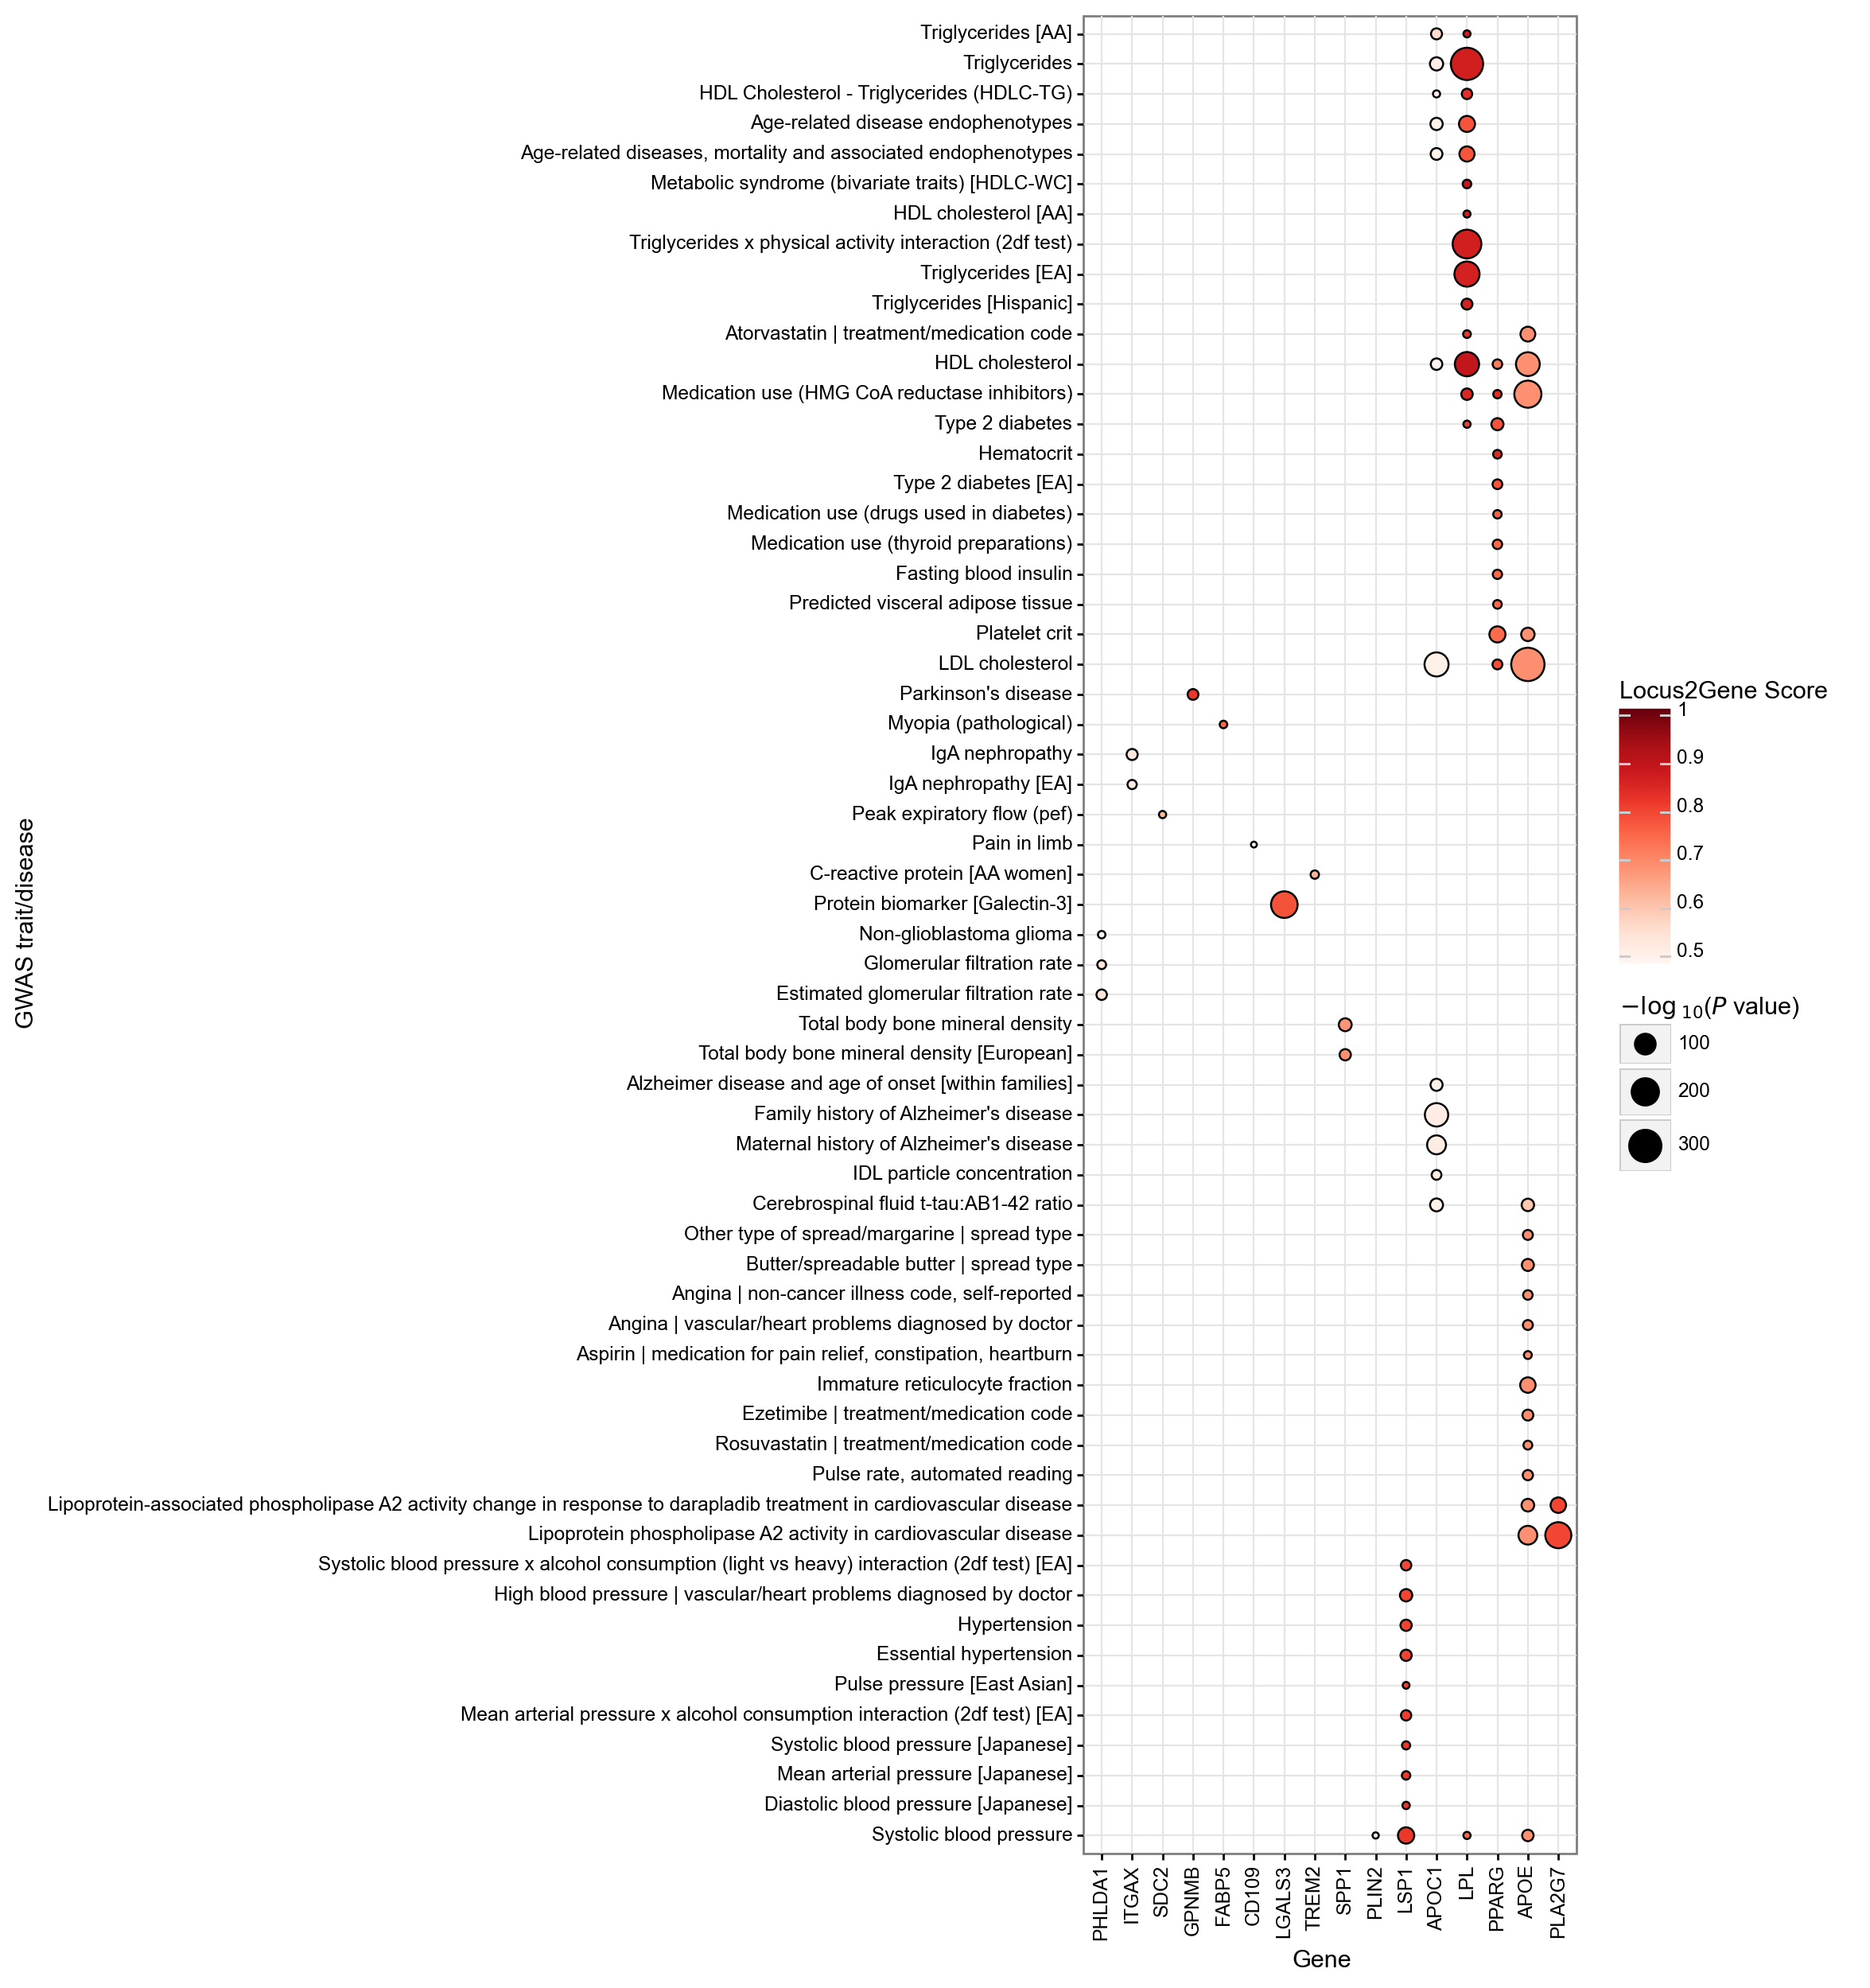

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 15 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure/Figure-S18H.pdf


In [21]:
g = lam_genes

lung_l2g = l2g_table[l2g_table.bestLocus2Genes_symbol.isin(g)].copy().sort_values('bestLocus2Genes_score', ascending=False)
gwas_final_table.append(lung_l2g.assign(myeloid_state = 'LAM-like'))

tr = lung_l2g.loc[lung_l2g.groupby('bestLocus2Genes_symbol').bestLocus2Genes_score.nlargest(10).reset_index().level_1.values].traitReported
lung_l2g = lung_l2g[lung_l2g.traitReported.isin(tr)]

df = lung_l2g.pivot('traitReported', 'bestLocus2Genes_symbol', 'bestLocus2Genes_score').fillna(0)
idx = sort_by_correlation(df, method='ward', metric='euclidean')
cats = df.index[idx][::-1]

idx = sort_by_correlation(df, rows=False)
genes = df.columns[idx]

lung_l2g['traitReported'] = pd.Categorical(lung_l2g['traitReported'], categories=cats)
lung_l2g['bestLocus2Genes_symbol'] = pd.Categorical(lung_l2g['bestLocus2Genes_symbol'], categories=genes)


g = (
    ggplot(aes(y='traitReported', x='bestLocus2Genes_symbol'), data=lung_l2g) + 
    geom_point(aes(fill='bestLocus2Genes_score', size='pval'), color='black') + 
    scale_fill_cmap('Reds', limits=(0.5, 1)) + 
    scale_size_continuous(range=(1,8)) +
    labs(y='GWAS trait/disease', x='Gene', fill='Locus2Gene Score', size='$-{\log}_{10}$($P$ value)') +
    theme_bw() + 
    theme(figure_size=(4, 15), axis_text_x=element_text(rotation=90), text=element_text(color='black', family='Arial'))
)

print(g)